In [3]:
import numpy as np
import argparse
import cv2
import os
import glob
from PIL import Image # This will be used to read/modify images (can be done via OpenCV too)
from numpy import *
#from skimage.feature import hog

In [25]:
# define parameters of HOG feature extraction
orientations = 9
pixels_per_cell = (16, 16)
cells_per_block = (2, 2)

# define path to images:
pos_im_path = r"/media/dtu-project2/2GB_HDD/Detection_HOG_SVM/dataset/bigger_dataset_128_64/pos" # This is the path of our positive input dataset
neg_im_path = r"/media/dtu-project2/2GB_HDD/Detection_HOG_SVM/dataset/bigger_dataset_128_64/neg"

# read the image files:
pos_im_listing = os.listdir(pos_im_path) # it will read all the files in the positive image path (so all the required images)
neg_im_listing = os.listdir(neg_im_path)
num_pos_samples = size(pos_im_listing) # simply states the total no. of images
num_neg_samples = size(neg_im_listing)
print(num_pos_samples) # prints the number value of the no.of samples in positive dataset
print(num_neg_samples)
data= []
labels = []

2638
2448


In [27]:
winSize = (64,128)
(a,b) = (16,16)

cellSize = (a,b)
blockSize = (2*a, 2*b)
blockStride = cellSize
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog_cv = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)


img = cv2.imread("46.jpg")

img = cv2.resize(img, ( img.shape[1]+1, img.shape[0]+1))

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


fd = hog_cv.compute(gray, winStride=(16,16), padding=(0,0))

print(hog_cv.getDescriptorSize())
print(hog_cv.checkDetectorSize())

print(fd.shape)

756
True
(756,)


In [28]:
data_mat = []

for file in pos_im_listing: #this loop enables reading the files in the pos_im_listing variable one by one
    filename = os.path.join(pos_im_path, file)
    #print(file)
    #img = Image.open(filename)#+ '\\/home/ubuntu18/Downloads/Object-detection-via-HOG-SVM-master/positive')
    #gray = img.convert('L') # convert the image into single channel i.e. RGB to grayscale
    img = cv2.imread(filename)
    img = cv2.resize(img, ( img.shape[1]+1, img.shape[0]+1))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # calculate HOG for positive features
    #fd = hog(gray, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True)
    fd = hog_cv.compute(gray, winStride=(16,16), padding=(0,0))
    #fd = np.expand_dims(fd, axis=0)
    #print(fd.shape)
    data_mat.append(fd)
    #data_mat = np.vstack([data_mat, fd])
    #print(labels)
# create labels

# Same for the negative images
for file in neg_im_listing: #this loop enables reading the files in the pos_im_listing variable one by one
    filename = os.path.join(neg_im_path, file)
    #print(file)
    #img = Image.open(filename)
    #gray= img.convert('L')
    img = cv2.imread(filename)
    img = cv2.resize(img, ( img.shape[1]+1, img.shape[0]+1))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Now we calculate the HOG for negative features
    #fd = hog(gray, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True) 
    fd = hog_cv.compute(gray, winStride=(16,16), padding=(0,0))
    #fd = np.expand_dims(fd, axis=0)
    #print(fd.shape)
    #data_mat = np.vstack([data_mat, fd])
    data_mat.append(fd)
    
trainingData = np.matrix(data_mat, dtype=np.float32)
print(trainingData.shape)
print(fd.shape)

(5086, 756)
(756,)


In [29]:
# create labels
pos_labels = np.ones((num_pos_samples, 1))
neg_labels = np.zeros((num_neg_samples, 1))

labels_mat = np.vstack([pos_labels, neg_labels])
responses = np.matrix(labels_mat, dtype = np.int32)

In [30]:
#take some data for testing out of complete data
n = 500

#test data division
testDatapos = trainingData[num_pos_samples-n:num_pos_samples, :]
testDataneg = trainingData[num_pos_samples+num_neg_samples-n:num_pos_samples+num_neg_samples, :]
testresppos = np.ones((n,1), dtype=np.int32)
testrespneg = np.zeros((n,1), dtype=np.int32)
testData = np.vstack([testDatapos, testDataneg])
testResp = np.vstack([testresppos, testrespneg])

#trainData
trainDatapos = trainingData[0:num_pos_samples-n, :]
trainDataneg = trainingData[num_pos_samples:num_pos_samples+num_neg_samples-n, :]
trainingData = np.vstack([trainDatapos, trainDataneg])
trainResppos = np.ones((num_pos_samples-n, 1), dtype=np.int32)
trainrespneg = np.zeros((num_neg_samples-n, 1), dtype=np.int32)
trainResp = np.vstack([trainResppos, trainrespneg])

print(trainingData.shape, trainResp.shape)
print(testData.shape, testResp.shape)

(4086, 756) (4086, 1)
(1000, 756) (1000, 1)


In [9]:
# train svm trainauto (https://docs.opencv.org/3.4/d1/d2d/classcv_1_1ml_1_1SVM.html)
# Train the SVM
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 5000, 1e-6))

svm.train(trainingData, cv2.ml.ROW_SAMPLE, trainResp)
#save the trained coefficients
#svm.save("svm_pedestrian_detector.xml")

True

In [10]:
# save the trained SVM model
filename = "hog_svm_pedestrain_detector_opencv_imp.dat"
svm.save(filename)

In [11]:
#load svm
svm2 = cv2.ml.SVM_load(filename)
print(svm2)

<ml_SVM 0x7efe20560e70>


In [18]:
import time
# test
TP = 0
FP = 0
TN = 0
FN = 0

dura = []
for i in range(testData.shape[0]):
    st = time.time()
    response = svm2.predict(testData[i,:])[1]
    dur = time.time()- st
    dura.append(dur)

    if response[0][0] == testResp[i][0] == 1.0:
        TP += 1
    if response[0][0] == testResp[i][0] == 0.0:
        TN += 1
    if response[0][0] != testResp[i][0]  and  testResp[i][0] == 1.0:
        FN += 1
    if response[0][0] != testResp[i][0] and testResp[i][0] == 0.0:
        FP += 1

P = TP/(TP+FP)
R = TP/(TP+FN)
A = (TP+TN)/(TP+TN+FP+FN)
F1 = 2*TP/(2*TP+FP+FN)

print("TP: ", TP, "FP: ", FP, "TN: ", TN, "FN: ", FN, "\n")
print("Precision:\t", P)
print("Recall:\t\t", R)
print("F1:\t\t", F1)
print("Accuracy:\t", A)

time_mean = np.mean(dura)
print("average prediction time", time_mean*5000)

TP:  479 FP:  27 TN:  473 FN:  21 

Precision:	 0.9466403162055336
Recall:		 0.958
F1:		 0.952286282306163
Accuracy:	 0.952
average prediction time 0.08670210838317871


In [20]:
'''vector< float > get_svm_detector( const Ptr< SVM >& svm )
{
    // get the support vectors
    Mat sv = svm->getSupportVectors()
    ();
    const int sv_total = sv.rows;
    // get the decision function
    Mat alpha, svidx;
    double rho = svm->getDecisionFunction( 0, alpha, svidx );
    CV_Assert( alpha.total() == 1 && svidx.total() == 1 && sv_total == 1 );
    CV_Assert( (alpha.type() == CV_64F && alpha.at<double>(0) == 1.) ||
               (alpha.type() == CV_32F && alpha.at<float>(0) == 1.f) );
    CV_Assert( sv.type() == CV_32F );
    vector< float > hog_detector( sv.cols + 1 );
    memcpy( &hog_detector[0], sv.ptr(), sv.cols*sizeof( hog_detector[0] ) );
    hog_detector[sv.cols] = (float)-rho;
    return hog_detector;
}'''

def get_svm_detector(svm):
    sv = svm.getSupportVectors()
    sv_total = sv.shape[0]
    rho, alpha, svidx  = svm.getDecisionFunction(0)
    hog_detector = np.ones((sv.shape[1]+1, 1))
    hog_detector[:hog_detector.shape[0]-1, :] = np.transpose(sv)
    #print(hog_detector.shape, "jjjjj")
    #print(hog_detector)
    hog_detector[sv.shape[1]] == -rho
    #print(-rho)
    #hog_detector = np.transpose(hog_detector)
    #print(hog_detector.shape)
    return hog_detector


In [21]:
# testing on full images from gazebo environment


'''
winSize = (128,64)
blockSize = (32,32)
blockStride = (8,8)
cellSize = (16,16)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 0
nlevels = 64

hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                        histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
'''
#HOGCV = cv2.HOGDescriptor()
#HOGCV.save("hog.xml")
hog_cv.setSVMDetector(get_svm_detector(svm2))

In [22]:
def plot_boxes(img, rects):
    for rect in rects:
        cv2.rectangle(img, (rect[0], rect[1]), (rect[2], rect[3]), color=(0, 0, 255), thickness=2)
    return img

(720, 1280, 3)
[[596 260  95 191]]
10.968431949615479


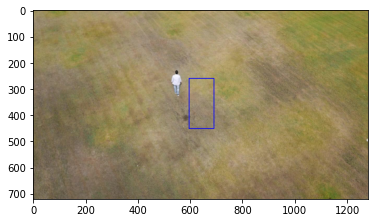

(720, 1280, 3)
[[595 259  95 190]]
11.060602188110352


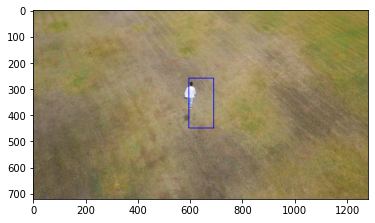

(720, 1280, 3)
[[595 261  95 191]]
10.929417133331299


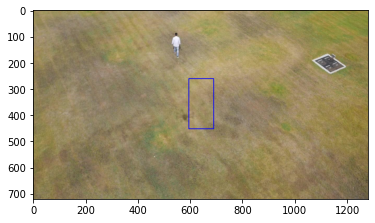

(720, 1280, 3)
[[598 260  95 191]]
10.953524827957153


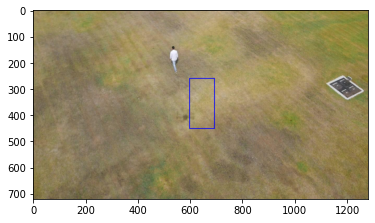

(360, 640, 3)
[[288  95  83 167]]
0.314316987991333


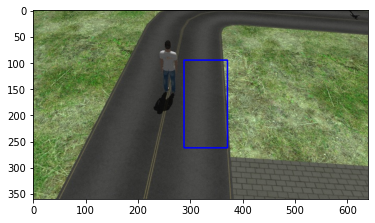

(360, 640, 3)
[[278  95  83 167]]
0.3136634826660156


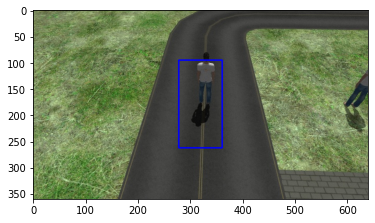

(360, 640, 3)
[[288  96  84 168]]
0.3642885684967041


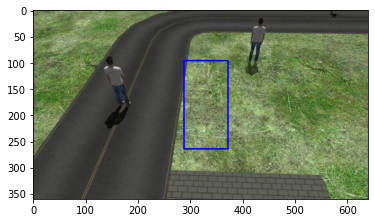

(360, 640, 3)
[[288  97  82 165]]
0.3241100311279297


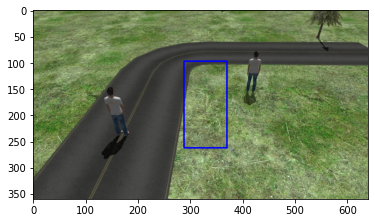

(360, 640, 3)
[[283  93  84 167]]
0.30632972717285156


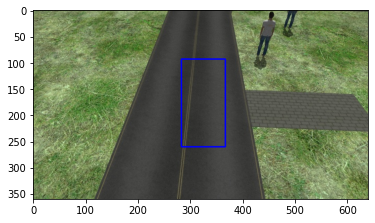

(360, 640, 3)
[[280  94  83 167]]
0.3207063674926758


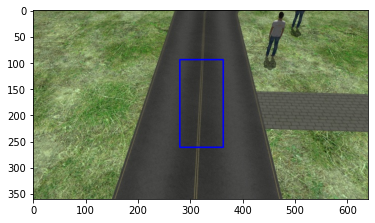

(360, 640, 3)
[[275  94  84 168]]
0.383258581161499


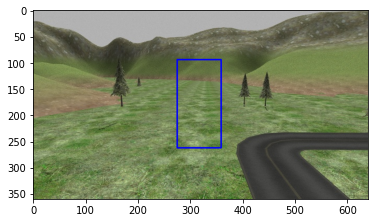

(360, 640, 3)
[[273  94  84 167]]
0.37302374839782715


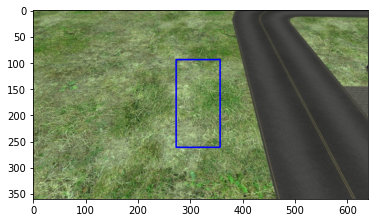

(360, 640, 3)
[[272  94  84 168]]
0.36991357803344727


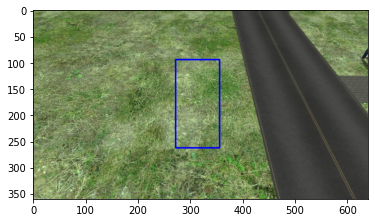

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
from imutils.object_detection import non_max_suppression

img_folder = "/home/dtu-project2/catkin_ws/src/image_processor/image_database/gazebo_pedestrian_test"
imgs = os.listdir(img_folder)
imgs.sort()

#print(hog_cv.getDescriptorSize())
#print(hog_cv.checkDetectorSize())
#hog_cv.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())


for name in imgs:
    st = time.time()
    filen = os.path.join(img_folder, name)
    img = cv2.imread(filen)
    print(img.shape )
    if img.shape == (128, 64, 3):
        img = cv2.resize(img, (65,129))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    rects, weights = hog_cv.detectMultiScale(img, winStride=(8, 8), padding=(8, 8), scale=1.1)
    print(rects)
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    print(time.time() - st)
    st = time.time()
    detected_boxes = non_max_suppression(rects, probs=None, overlapThresh=0.9)
    #print(detected_boxes)
    img = plot_boxes(img, detected_boxes)
    plt.figure()
    plt.imshow(img)
    plt.show()